In [1]:
# load in the model class
import json
from sys import path
path.append("./model/")
import ModelNN as Net
import torch
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import numpy as np

#intialize values
seed=27
data_dir = './data/'
model_dir = './model/'
architecture = 'TwoLayer_750_epochs_optimized_roc_auc_score' # use whichever model name desired
peak_mmh = 'peak_i15_mmh'


# open the parameters json
file_name = "model_parameters.json"
with open(model_dir + file_name) as model_params:
    model_params = json.load(model_params)
# load in model parameters
one_model = model_params[architecture]

# should turn this into a function
input_size = len(one_model['features'])
hidden_size = one_model['hidden_size']
dropout_rate = one_model['dropout_rate']
output_size = 1

# this is not programmatic
model_class = one_model['model_class'] # it isn't getting passed in anywhere
# load feature set
features = one_model['features']
# load trained model weights file_name
weights = one_model['weights']

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# instantiate model
model = Net.TwoLayer(input_size, hidden_size, output_size, dropout_rate).to(device)
# load weights/biases
model.load_state_dict(torch.load(model_dir + weights, map_location=device))

# LOAD IN DATA
# needed to scale to training set
X_train_df, X_test_df, y_train_df, y_test_df = pickle.load(open(data_dir + "train_test_data.pkl", "rb"))
# delete the testing data, we don't need it
del X_test_df, y_test_df
X_train_df = X_train_df[features]

# scale on the training set
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train_df))
# we need to extract these for app runtime
# these will be used to scale the input data
rain_scaler_mean = X_train_df['peak_i15_mmh'].mean()
rain_scaler_std = X_train_df['peak_i15_mmh'].std()
### for example:
#### but swap out "rain" with the input paramater
#####rain_scaled = (rain - rain_scaler_mean) / rain_scaler_std

# now load in all the data
site_data = gpd.read_parquet(data_dir + "sites_v02_plot_data.parquet")
# need for replacing data in scaled df at inference
col_idx = site_data[features].columns.get_loc('peak_i15_mmh')

# fit the data to the scaler
X_scaled = pd.DataFrame(sc.transform(site_data[features]))
# change to tensor
# X_scaled_tensor = torch.tensor(X_scaled.values).float().to(device)
# # make prediction
# y_pred_tensor = model(X_scaled_tensor) # already sent to device when instantiated
# # convert back dtype
# y_pred_proba = y_pred_tensor.detach().cpu().numpy().astype(np.float16) # smaller dtype
# y_pred_bool = np.round(y_pred_proba)
print('loaded')

loaded


In [2]:
site_data.shape

(693, 24)

In [3]:
site_data['geom'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
site_data['geometry_simple'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# calculate center of map for initializing to our data
# ignore this warning
map_center = {
    "lon": site_data['geometry_simple'].centroid.x.median(),
    "lat": site_data['geometry_simple'].centroid.y.median(),
}

/var/folders/p6/0v7dt7_x1p336nsn9fhywqq40000gn/T/ipykernel_7135/3368206389.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "lon": site_data['geometry_simple'].centroid.x.median(),
/var/folders/p6/0v7dt7_x1p336nsn9fhywqq40000gn/T/ipykernel_7135/3368206389.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "lat": site_data['geometry_simple'].centroid.y.median(),


https://plotly.com/python/builtin-colorscales/

In [6]:
# site_data['proba'] = 0.00

In [7]:
def make_prediction(plot_df, rain_input):
    rain = pd.to_numeric(np.repeat(rain_input, plot_df.shape[0]))
    rain_scaled = (rain - rain_scaler_mean) / rain_scaler_std
    # now replace with the scaled input
    X_scaled.loc[:,col_idx] = rain_scaled
    
    # and make prediction with the new rain amount
    X_scaled_tensor = torch.tensor(X_scaled.values).float().to(device)
    y_pred_tensor = model(X_scaled_tensor) # already sent to device when instantiated
    # predicted probability
    y_pred_proba = y_pred_tensor.detach().cpu().numpy().astype(np.float16) # smaller dtype
    # in case you want the binary output
    #y_pred_bool = np.round(y_pred_proba)
    
    return y_pred_proba

In [8]:
examine = site_data.copy()

mean proba:  0.01237


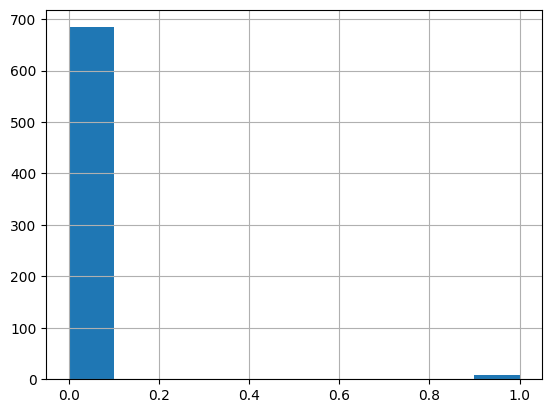

In [9]:
input_amt = 10

examine['proba'] = make_prediction(site_data, input_amt)
print('mean proba: ', examine['proba'].mean())
examine['proba'].hist();

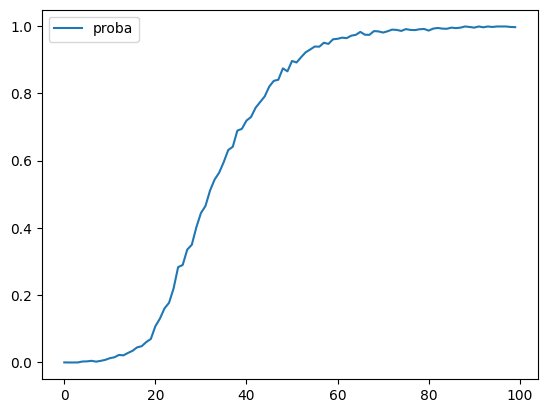

In [10]:
pred_df = pd.DataFrame(columns=['proba'])
for i in range(100):
    pred_df.loc[i, 'proba'] = make_prediction(site_data, i).mean()

pred_df.plot();

In [11]:
# MVP

from dash import Dash, dcc, html, Input, Output
import plotly.express as px

from jupyter_dash import JupyterDash # for dev
app = JupyterDash(__name__) # for dev
#app = Dash(__name__)

app.layout = html.Div([
    html.H1("Change the value in the text box to see updated probability of Debris Flow"),
    html.Div([
        "Input Upcoming Rain Forecase (mm/h): ",
         dcc.Input(id='rain_input', value='10', type='number', step="1", min=0)
    ]),
    html.Br(),
    html.Div([
        dcc.Graph(id='map_plot',
        )
    ]),
])


# define initial map function
def create_plot(plot_df):
       
    # create the plot with our new proba
    fig = px.choropleth_mapbox(
        plot_df,
        plot_df['geometry_simple'], # this is the area
        locations=plot_df.index, # needed to match all data correctly
        color='proba',
        range_color=(0, 1),
        color_continuous_scale='OrRd',
        #color_continuous_scale='RdBu_r',
        #color_continuous_scale='Blackbody_r',
        hover_name='state',
        # format what's displayed
        # trouble disabling the index from displayinin hover
        hover_data={
            'proba':':,.0%',
        },
        center=map_center,
        mapbox_style='stamen-terrain',
        height=800,
        zoom=7,
        opacity=0.5,
    )
    
    fig2 = px.scatter_mapbox(
        plot_df,
        lat='lat', # point data
        lon='lon', # point data
        #color_discrete_map={'Debris-Flow': 'orange'},
        size_max=6,
        hover_data=['flowdate'],
        #mapbox_style='stamen-terrain', # not needed when adding traces
    )
    # combine plots
    fig.add_traces(fig2.data)
    #fig.show()
    #return fig
    
    fig.update_coloraxes(
        colorbar_title='probability',
        #colorbar_tick0=0,
        cmin=0,
        cmax=1,
        colorbar_tickformat='.0%',
        #color_tickvals=[.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0],
        #colorbar_tickmode='array',# array supposedly default if tickvals works
        #colorbar_nticks=10,
        #colorbar_dticks=.10,
    )
    
    fig.update_layout(
        title='Debris Flow Prediction',
        #uirevision='true',
        uirevision=True, # sometimes buggy but keeps zoom from resetting when input changes
        #coloraxis_colorbar_x=0.01, # move to left side of screen
        hoverlabel=dict(
            font_size=14,
        ),
    )
    # fig.update_traces(
    #     hovertemplate={
    #         'proba':':,.0%',
    # },)
    return fig

@app.callback(
    #Output(component_id='my_output', component_property='children'),
    Output(component_id='map_plot', component_property='figure'),
    Input(component_id='rain_input', component_property='value')
)

def display_map(input_value):
    # fit the scaler on the input
    rain_arr = pd.to_numeric(np.repeat(input_value, site_data.shape[0]))
    rain_arr_scaled = (rain_arr - rain_scaler_mean) / rain_scaler_std
    # now replace with the scaled input
    X_scaled.loc[:,col_idx] = rain_arr_scaled
    # pass to tensor
    X_scaled_tensor = torch.tensor(X_scaled.values).float().to(device)
    # and make prediction with the new rain amount
    y_pred_tensor = model(X_scaled_tensor) # already sent to device when instantiated
    # predicted probability, passed back to numpy
    y_pred_proba = y_pred_tensor.detach().cpu().numpy().astype(np.float16) # smaller dtype
    # in case you want the binary output for something
    #y_pred_bool = np.round(y_pred_proba)
    site_data['proba'] = y_pred_proba
    
    return create_plot(site_data)

if __name__ == '__main__':
    app.run_server(
        debug=True,
        mode='inline',
        #host='localhost',
        #port=8090,
        #dev_tools_ui=True, 
        #dev_tools_hot_reload=True, 
        #threaded=True,
    )
#webbrowser.open("http://127.0.0.1:8050/") # can open automatically to save a click

Dash is running on http://127.0.0.1:8050/



Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.

In [ ]:
help(px.choropleth)

In [13]:
app.run_server?

Signature:
app.run_server(
    mode=None,
    width='100%',
    height=650,
    inline_exceptions=None,
    **kwargs,
)
Docstring:
Serve the app using flask in a background thread. You should not run this on a
production server, use gunicorn/waitress instead.

:param mode: Display mode. One of:
    ``"external"``: The URL of the app will be displayed in the notebook
        output cell. Clicking this URL will open the app in the default
        web browser.
    ``"inline"``: The app will be displayed inline in the notebook output cell
        in an iframe.
    ``"jupyterlab"``: The app will be displayed in a dedicate tab in the
        JupyterLab interface. Requires JupyterLab and the `jupyterlab-dash`
        extension.
:param width: Width of app when displayed using mode="inline"
:param height: Height of app when displayed using mode="inline"
:param inline_exceptions: If True, callback exceptions are displayed inline
    in the the notebook output cell. Defaults to True if mode=="inl